In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import anndata
from sklearn.linear_model import LinearRegression
from upsetplot import from_indicators, from_contents
from upsetplot import plot as upset
import matplotlib
from mx.mx_inspect import mx_inspect_rows, mx_inspect_cols
fsize=15

def nd(arr):
  return np.asarray(arr).reshape(-1)

def yex(ax):
  lims = [
      np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
      np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
  ]

  # now plot both limits against eachother
  ax.plot(lims, lims, 'white', alpha=0.75, zorder=0)
  ax.set(**{
      "aspect": "equal",
      "xlim": lims,
      "ylim": lims
  })
  return ax

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [28]:
# only filter barcodes for atac_x
filter_bcs = pd.read_csv("/home/sina/projects/atac/scATAK/data/10xPBMC/atac_x/out_cr_peaks_cr_quant/quant-cr/outs/filtered_peak_bc_matrix/barcodes.txt", header=None, names=["bcs"])

acc = anndata.read_h5ad("/home/sina/projects/atac/scATAK/data/10xPBMC/atac_c/out_kb_peaks_subsam/adata.h5ad")
acx = anndata.read_h5ad("/home/sina/projects/atac/scATAK/data/10xPBMC/atac_x/out_kb_peaks_subsam/adata.h5ad")
mcc = anndata.read_h5ad("/home/sina/projects/atac/scATAK/data/10xPBMC/mome_c/out_kb_peaks_subsam/adata.h5ad")
mcx = anndata.read_h5ad("/home/sina/projects/atac/scATAK/data/10xPBMC/mome_x/out_kb_peaks_subsam/adata.h5ad")

In [30]:
accmask = nd(acc.X.sum(0))==0
acxmask = nd(acx.X.sum(0))==0
mccmask = nd(mcc.X.sum(0))==0
mcxmask = nd(mcx.X.sum(0))==0

common_mask = np.logical_or.reduce((accmask,acxmask,mccmask,mcxmask))

In [31]:
accmask.sum(), acxmask.sum(), mccmask.sum(), mcxmask.sum(), common_mask.sum()

(1097, 1093, 982, 990, 1212)

In [32]:
peaks = acc.var.index.values
ind = {
  "ATAC-X": peaks[nd(acx.X.sum(0)>0).astype(bool)],
  "ATAC-C": peaks[nd(acc.X.sum(0)>0).astype(bool)],
  "MOME-X": peaks[nd(mcx.X.sum(0)>0).astype(bool)],
  "MOME-C": peaks[nd(mcc.X.sum(0)>0).astype(bool)]
}
blah = from_contents(ind)

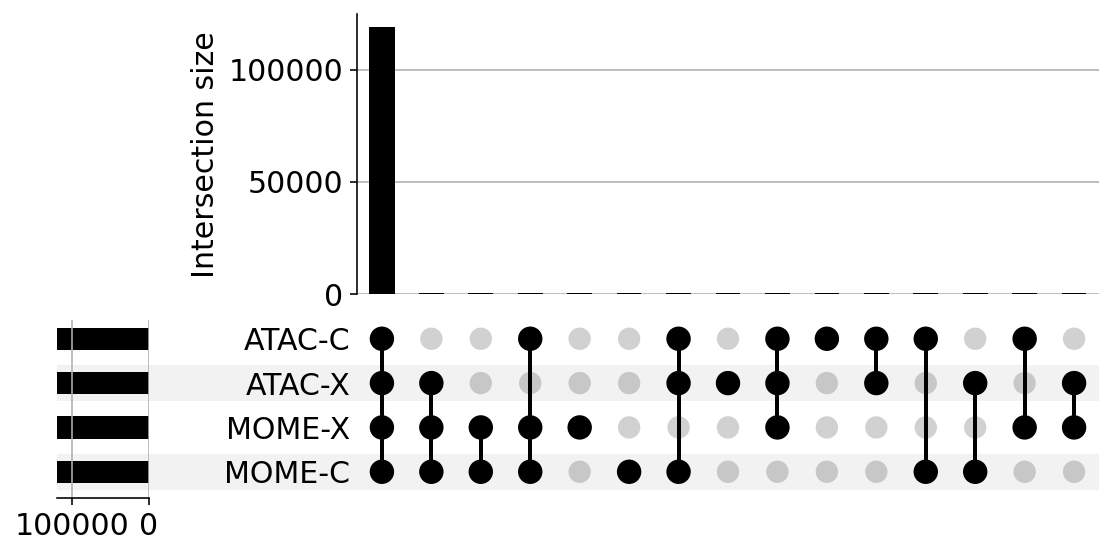

In [33]:
fig = plt.figure(figsize=(10,10))
upset(blah, fig=fig, sort_by="cardinality")
fig.show()

In [34]:
peaks = acc.var.index.values
ind = {
  "ATAC-X": peaks[common_mask][nd(acx[:,common_mask].X.sum(0)>0).astype(bool)],
  "ATAC-C": peaks[common_mask][nd(acc[:,common_mask].X.sum(0)>0).astype(bool)],
  "MOME-X": peaks[common_mask][nd(mcx[:,common_mask].X.sum(0)>0).astype(bool)],
  "MOME-C": peaks[common_mask][nd(mcc[:,common_mask].X.sum(0)>0).astype(bool)]
}
blah = from_contents(ind)

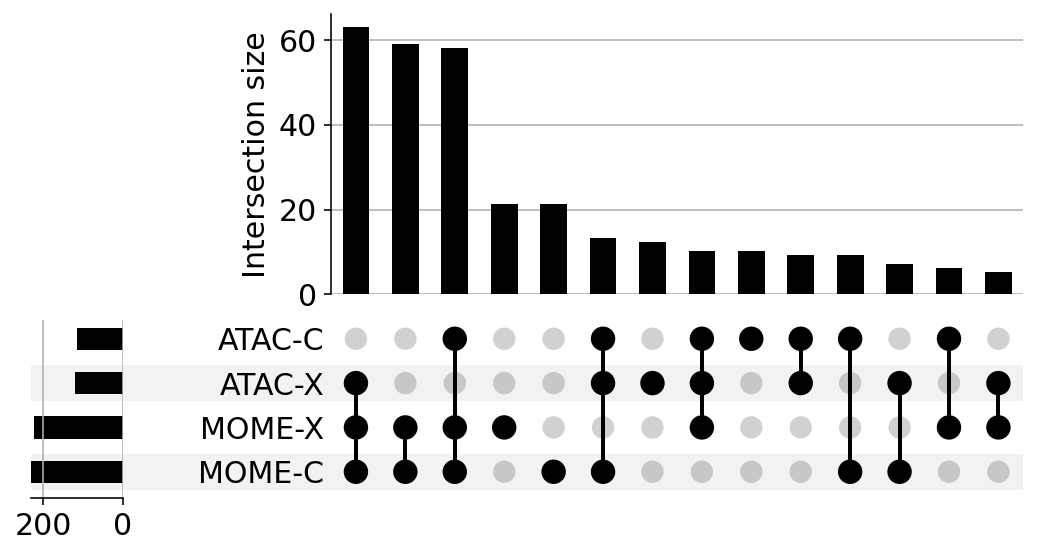

In [35]:
fig = plt.figure(figsize=(10,10))
upset(blah, fig=fig, sort_by="cardinality")
fig.show()

In [36]:
print(acc.shape, acx.shape, mcc.shape, mcx.shape, sep="\n")

(429549, 119876)
(435602, 119876)
(639644, 119876)
(646285, 119876)


In [17]:
data = {"ATAC-C": acc, "ATAC-X": acx, "MOME-C": mcc, "MOME-X": mcx}
order = [
"ATAC-C",
"ATAC-X",
"MOME-C",
"MOME-X",
]

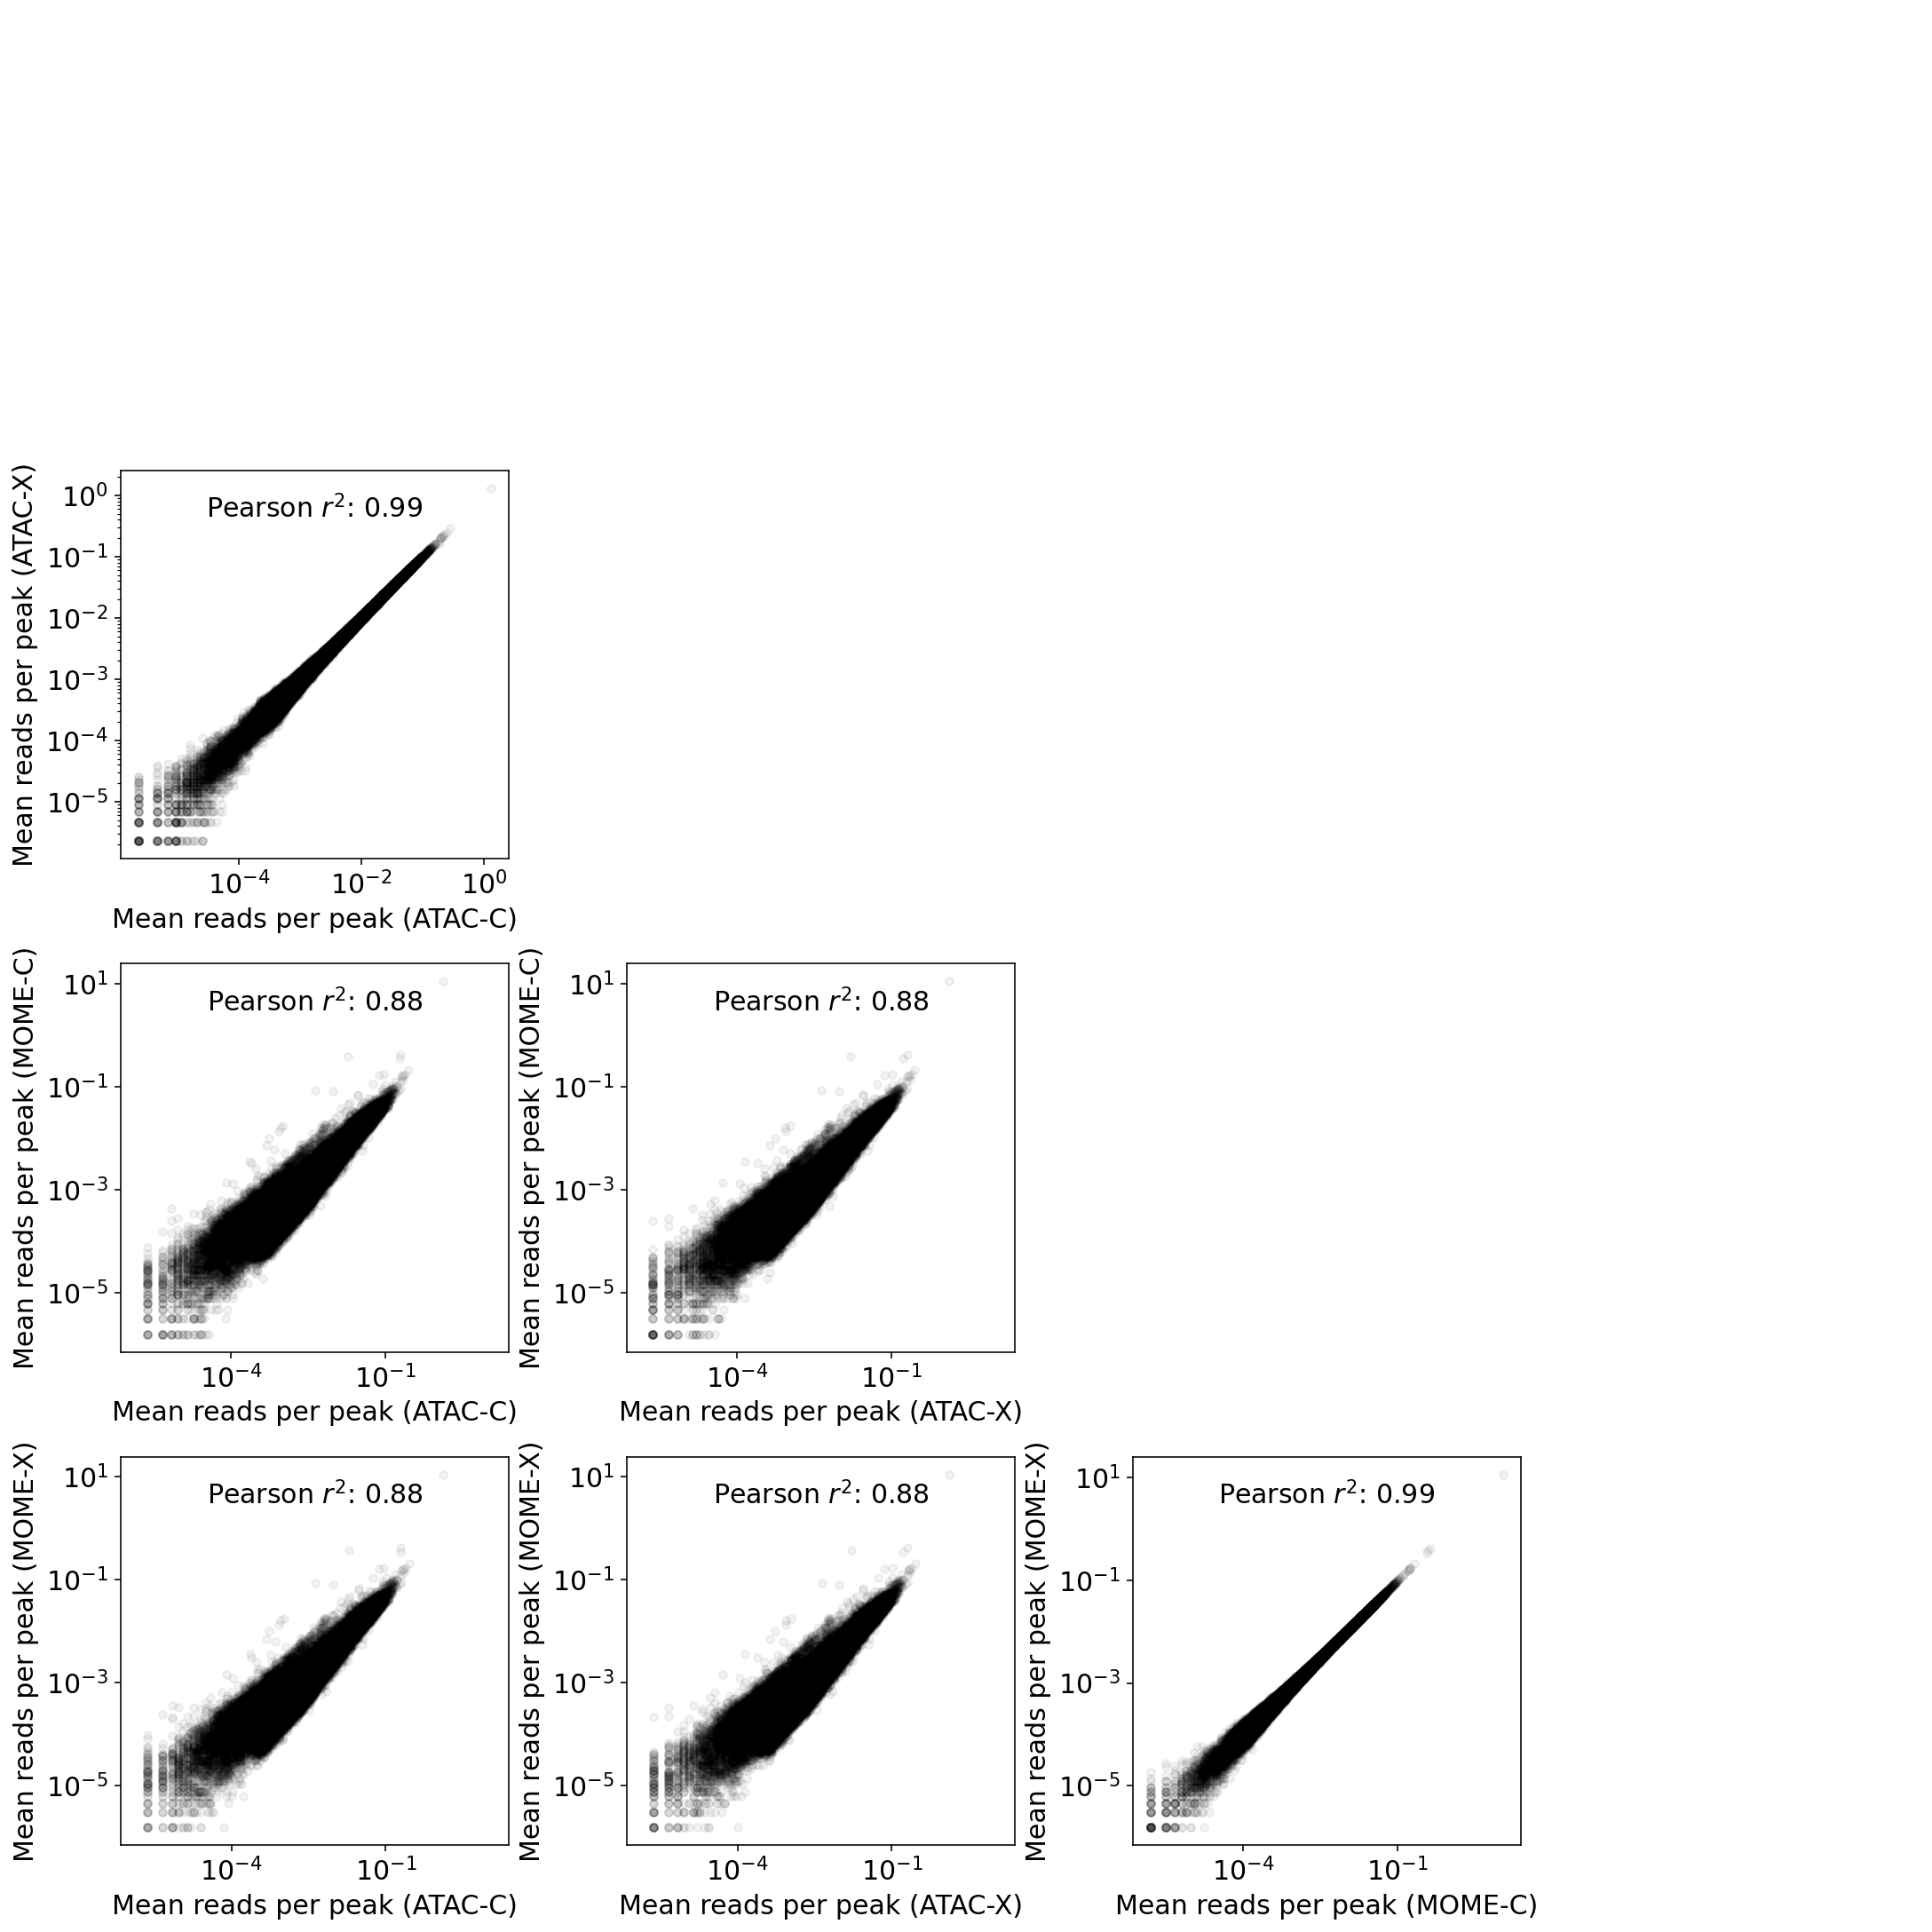

In [26]:
fig, axs = plt.subplots(figsize=(15,15), ncols=4, nrows=4, constrained_layout=True)
# fig.subplots_adjust(hspace=.1, wspace=0.1)


kwd = {
    "xscale": "log",
    "yscale": "log",
}

for i in range(4):
    for j in range(4):
        ax = axs[i, j]
        if i<=j:
            ax.set_axis_off()


for i in range(4):
    for j in range(i):
        ax = axs[i, j]
        xlabel = order[j]
        ylabel = order[i]

        x = data[xlabel].var["counts_mean"].values
        y = data[ylabel].var["counts_mean"].values
        mask = np.logical_and(x>0, y>0)

        ax.scatter(x, y, alpha=0.05, s=20, color="k")
        kwd.update({"xlabel": f"Mean reads per peak ({xlabel})"})
        kwd.update({"ylabel": f"Mean reads per peak ({ylabel})"})
        ax.set(**kwd)

        yex(ax)
        lx, ly = np.log(x[mask]).reshape(-1,1), np.log(y[mask])
        reg = LinearRegression().fit(lx, ly)
        r2 = reg.score(lx, ly)

        ax.text(0.5, 0.9, f"Pearson $r^2$: {r2:,.2f}",
            horizontalalignment='center',
            verticalalignment='center',
            transform = ax.transAxes)
fig.savefig("figures/10x_tech_comparison_peaks.png", bbox_inches="tight", dpi=300)
fig.show()

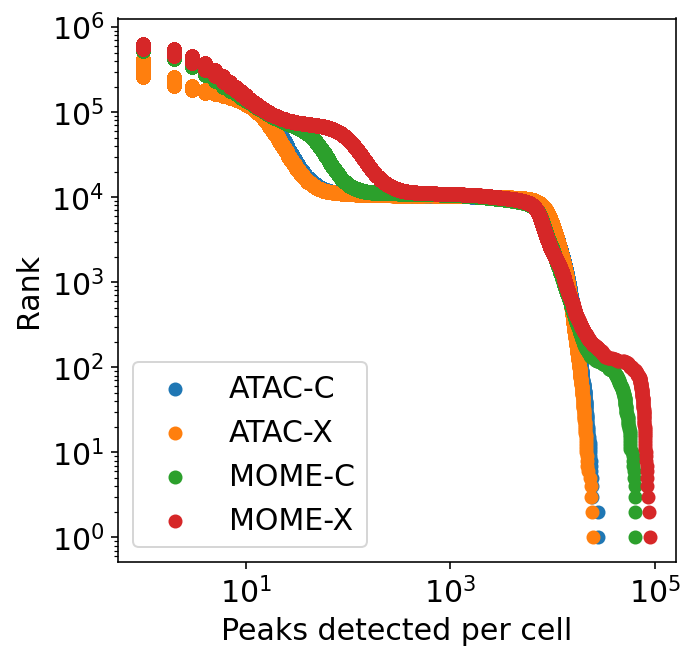

In [27]:
fig, ax = plt.subplots(figsize=(5,5))

for name in order:
    x = data[name].obs["counts_nnzero"].sort_values(ascending=False)
    y = np.arange(x.shape[0])
    ax.scatter(x,y, label=name)

    ax.set(**{
        "xscale": "log",
        "yscale": "log",
        "xlabel": "Peaks detected per cell",
        "ylabel": "Rank",
    })
ax.legend()
fig.savefig("figures/10x_tech_comparison_cells.png", bbox_inches="tight", dpi=300)
fig.show()